In [1]:
%reset
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
from matplotlib.pyplot import cm
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
# solves G''(z) + (N^2(z) - omega^2)G(z)/c^2 = 0 
#   subject to G'(0) = gG(0)/c^2 (free surface) & G(-D) = 0 (flat bottom)
# G(z) is normalized so that the vertical integral of (G'(z))^2 is D
# G' is dimensionless, G has dimensions of length

# - N is buoyancy frequency [s^-1] (nX1 vector)
# - depth [m] (maximum depth is considered the sea floor) (nX1 vector)
# - omega is frequency [s^-1] (scalar)
# - mmax is the highest baroclinic mode calculated
# - m=0 is the barotropic mode
# - 0 < m <= mmax are the baroclinic modes
# - Modes are calculated by expressing in finite difference form 1) the
#  governing equation for interior depths (rows 2 through n-1) and 2) the
#  boundary conditions at the surface (1st row) and the bottome (last row).
# - Solution is found by solving the eigenvalue system A*x = lambda*B*x
def vertical_modes(N2_0, Depth, omega, mmax):
    z = -1 * Depth

    if np.size(np.shape(N2_0)) > 1:
        N2 = np.nanmean(N2_0, axis=1)
    else:
        N2 = N2_0

    n = np.size(z)
    nm1 = n - 1
    nm2 = n - 2
    gravity = 9.82
    # ----- vertical increments
    dz = np.concatenate([[0], z[1:] - z[0:nm1]])  # depth increment [m]
    dzm = np.concatenate([[0], 0.5 * (z[2:] - z[0:nm2]), [0]])  # depth increment between midpoints [m]
    # ----- sparse matrices
    # A = row pos, B = col pos, C = val  
    A = np.concatenate([[0], [0], np.arange(1, nm1), np.arange(1, nm1), np.arange(1, nm1), [n - 1]])
    B = np.concatenate([[0], [1], np.arange(1, nm1), np.arange(0, nm2), np.arange(2, n), [n - 1]])
    C = np.concatenate(
        [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
         -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
        # [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
        #  -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
    mat1 = coo_matrix((C, (A, B)), shape=(n, n))

    D = np.concatenate([[0], np.arange(1, n)])
    E = np.concatenate([[0], np.arange(1, n)])
    F = np.concatenate([[gravity], N2[1:] - omega * omega])  # originially says N2[1:,10]
    mat2 = coo_matrix((F, (D, E)), shape=(n, n))

    # compute eigenvalues and vectors 
    vals, vecs = eigs(mat1, k=mmax + 1, M=mat2, sigma=0)
    eigenvalue = np.real(vals)
    wmodes = np.real(vecs)
    s_ind = np.argsort(eigenvalue)
    eigenvalue = eigenvalue[s_ind]
    wmodes = wmodes[:, s_ind]
    m = np.size(eigenvalue)
    c = 1 / np.sqrt(eigenvalue)  # kelvin wave speed
    # normalize mode (shapes)
    Gz = np.zeros(np.shape(wmodes))
    G = np.zeros(np.shape(wmodes))
    for i in range(m):
        dw_dz = np.nan * np.ones(np.shape(z))
        dw_dz[0] = (wmodes[1, i] - wmodes[0, i]) / (z[1] - z[0])
        dw_dz[-1] = (wmodes[-1, i] - wmodes[-2, i]) / (z[-1] - z[-2])
        for j in range(1, len(z) - 1):
            dw_dz[j] = (wmodes[j + 1, i] - wmodes[j - 1, i]) / (z[j + 1] - z[j - 1])
        # dw_dz = np.gradient(wmodes[:, i], z)
        norm_constant = np.sqrt(np.trapz((dw_dz * dw_dz), (-1 * z)) / (-1 * z[-1]))
        # norm_constant = np.abs(np.trapz(dw_dz * dw_dz, z) / Depth.max())

        if dw_dz[0] < 0:
            norm_constant = -1 * norm_constant
        Gz[:, i] = dw_dz / norm_constant

        norm_constant_G = np.sqrt(np.trapz((wmodes[:, i] * wmodes[:, i]), (-1 * z)) / (-1 * z[-1]))
        G[:, i] = wmodes[:, i] / norm_constant

    #epsilon = np.nan * np.zeros((5, 5, 5))  # barotropic and first 5 baroclinic
    #for i in range(0, 5):  # i modes
    #    for j in range(0, 5):  # j modes
    #        for m in range(0, 5):  # k modes
    #            epsilon[i, j, m] = np.trapz((Gz[:, i] * Gz[:, j] * Gz[:, m]), -1.0*z) / (-1.0*z[-1])

    return G, Gz, c#, epsilon
#G is the displacement modes and Gz is velocity modes (Gz = dG/dz = F)

Computing QG modes at an individual gridbox.

In [3]:
## Gustavo's default KHTH=300
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/KHTH_constant/nw2_0.5deg_N15_KHTH300 
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00032002.nc',decode_times=False)

## Gustavo's default KHTH=500
# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/KHTH_constant/nw2_0.5deg_N15_KHTH500
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00032002.nc',decode_times=False)
# os = xr.open_dataset('ocean.stats.nc',decode_times=False)


## MY default KHTH=300 (should be copy of Gustavo's above, just a sanity check since it was my first run)
# %cd /glade/p/univ/unyu0004/eyankovsky/example_elizabeth
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc',decode_times=False)
# os = xr.open_dataset('ocean.stats.nc',decode_times=False)

#PARAMETERIZED GME RUNS:
# %cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_attempt1
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc',decode_times=False)
# os = xr.open_dataset('ocean.stats.nc',decode_times=False)

# %cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_C01
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_mfdataset(['averages_00030002.nc','averages_00030502.nc','averages_00031002.nc','averages_00031502.nc'],decode_times=False)
# os = xr.open_dataset('ocean.stats.nc',decode_times=False)

# %cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_C1
# fs= xr.open_dataset('static.nc', decode_times=False)
# av = xr.open_dataset('averages_00031502.nc',decode_times=False)
# os = xr.open_dataset('ocean.stats.nc',decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_default
fs= xr.open_dataset('static.nc', decode_times=False)
av = xr.open_mfdataset(['averages_00030002.nc','averages_00030502.nc','averages_00031002.nc','averages_00031502.nc'],decode_times=False)
os = xr.open_dataset('ocean.stats.nc',decode_times=False)


# %cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.0625deg_N15_baseline/
# fs = xr.open_dataset('static.nc', decode_times=False)
# os = xr.open_dataset('ocean.stats.nc', decode_times=False)
# av = xr.open_dataset('averages_00006002.nc', decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/p/univ/unyu0004/eyankovsky/Bachman2019_KHTH500_default
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [4]:
#Read in various grid variables from the static file and forcing:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']

xh = fs.xh.values
yh = fs.yh.values

time=100

In [5]:
av

<xarray.Dataset>
Dimensions:     (nv: 2, time: 400, xh: 120, xq: 121, yh: 280, yq: 281, zi: 16, zl: 15)
Coordinates:
  * xh          (xh) float64 0.25 0.75 1.25 1.75 ... 58.25 58.75 59.25 59.75
  * yh          (yh) float64 -69.75 -69.25 -68.75 -68.25 ... 68.75 69.25 69.75
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time        (time) float64 3e+04 3.001e+04 3.001e+04 ... 3.199e+04 3.2e+04
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 0.0 0.5 1.0 1.5 2.0 ... 58.0 58.5 59.0 59.5 60.0
  * yq          (yq) float64 -70.0 -69.5 -69.0 -68.5 ... 68.5 69.0 69.5 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    KHTH_t      (time, zl, yh, xh) float32 dask.array<chunksize=(100, 15, 280, 120), meta=np.ndarray>
    GMwork      (time, yh, xh) float32 dask.array<chunksize=(100, 280, 120), meta=np.ndarray>
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(100, 15, 280, 121), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(100, 15, 281, 120), meta=np.ndarray>
    h           (time, zl, yh, xh) float32 dask.array<chunksize=(100, 15, 280, 120), meta=np.ndarray>
    e2          (time, zi, yh, xh) float32 dask.array<chunksize=(100, 16, 280, 120), meta=np.ndarray>
    e           (time, zi, yh, xh) float32 dask.array<chunksize=(100, 16, 280, 120), meta=np.ndarray>
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(100, 15, 280, 121), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(100, 15, 281, 120), meta=np.ndarray>
    PV          (time, zl, yq, xq) float32 dask.array<chunksize=(100, 15, 281, 121), meta=np.ndarray>
    dudt        (time, zl, yh, xq) float32 dask.array<chunksize=(100, 15, 280, 121), meta=np.ndarray>
    dvdt        (time, zl, yq, xh) float32 dask.array<chunksize=(100, 15, 281, 120), meta=np.ndarray>
    CAu         (time, zl, yh, xq) float32 dask.array<chunksize=(100, 15, 280, 121), meta=np.ndarray>
    CAv         (time, zl, yq, xh) float32 dask.array<chunksize=(100, 15, 281, 120), meta=np.ndarray>
    rvxu        (time, zl, yq, xh) float32 dask.array<chunksize=(100, 15, 281, 120), meta=np.ndarray>
    rvxv        (time, zl, yh, xq) float32 dask.array<chunksize=(100, 15, 280, 121), meta=np.ndarray>
    gKEu        (time, zl, yh, xq) float32 dask.array<chunksize=(100, 15, 280, 121), meta=np.ndarray>
    gKEv        (time, zl, yq, xh) float32 dask.array<chunksize=(100, 15, 281, 120), meta=np.ndarray>
    PFu         (time, zl, yh, xq) float32 dask.array<chunksize=(100, 15, 280, 121), meta=np.ndarray>
    PFv         (time, zl, yq, xh) float32 dask.array<chunksize=(100, 15, 281, 120), meta=np.ndarray>
    diffu       (time, zl, yh, xq) float32 dask.array<chunksize=(100, 15, 280, 121), meta=np.ndarray>
    diffv       (time, zl, yq, xh) float32 dask.array<chunksize=(100, 15, 281, 120), meta=np.ndarray>
    du_dt_visc  (time, zl, yh, xq) float32 dask.array<chunksize=(100, 15, 280, 121), meta=np.ndarray>
    dv_dt_visc  (time, zl, yq, xh) float32 dask.array<chunksize=(100, 15, 281, 120), meta=np.ndarray>
    u_BT_accel  (time, zl, yh, xq) float32 dask.array<chunksize=(100, 15, 280, 121), meta=np.ndarray>
    v_BT_accel  (time, zl, yq, xh) float32 dask.array<chunksize=(100, 15, 281, 120), meta=np.ndarray>
    KE          (time, zl, yh, xh) float32 dask.array<chunksize=(100, 15, 280, 120), meta=np.ndarray>
    dKE_dt      (time, zl, yh, xh) float32 dask.array<chunksize=(100, 15, 280, 120), meta=np.ndarray>
    PE_to_KE    (time, zl, yh, xh) float32 dask.array<chunksize=(100, 15, 280, 120), meta=np.ndarray>
    KE_BT       (time, zl, yh, xh) float32 dask.array<chunksize=(100, 15, 280, 120), meta=np.ndarray>
    KE_CorAdv   (time, zl, yh, xh) float32 dask.array<chunksize=(100, 15, 280, 120), meta=np.ndarray>
    KE_adv      (time, zl, yh, xh) float32 dask.array<chunksize=(100, 15, 280, 120), meta=np.ndarray>
    KE_visc     (time, zl, yh, xh) flo

In [8]:
#1/4 degree:560 lat x 240 lon 
#60,460 in 1/4 degree is nominal analysis point!
index_lon=90; index_lat=240 #1/4 degree: (60,460), (120,160), (60,80), (120,80), (200,80)

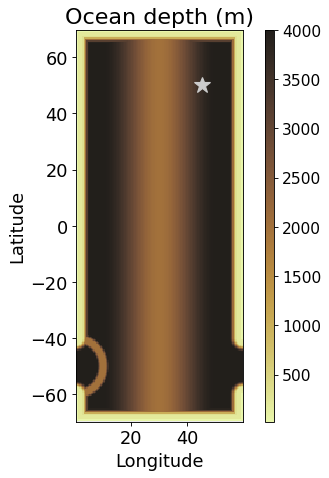

In [9]:
#Plotting ocean depth
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Ocean depth (m)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,depth,cmap=cmocean.cm.turbid)
ax1.plot(xh[index_lon],yh[index_lat],'*',markersize=15,color=[0.8, 0.8, 0.8])
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

In [10]:
Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(xh),1]);   Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)


v = np.nanmean(np.array(av['v'][:,:,index_lat-1:index_lat+1,index_lon]),axis=2);
u = np.nanmean(np.array(av['u'][:,:,index_lat,index_lon-1:index_lon+1]),axis=2); 
v=np.column_stack([v, 0.0*v[:,-1]]); u=np.column_stack([u, 0.0*u[:,-1]]) #add bottom BC point where u,v,=0

h = np.array(av['h'][:,:,index_lat,index_lon]);
eta = np.zeros([time,len(Layer)+1]);

for i in range(1,len(Layer)+1):
    for j in range(0,time):
        eta[j,i]=np.nansum(h[j,0:i])  
    print(i)
    
eta[:,:-1]=(eta[:,1:]+eta[:,:-1])/2. #add bottom BC point at topography where u,v=0

drhodz=drho/h
N2=(9.81/1022.6)*drhodz
N2=np.column_stack([N2, N2[:,-1]*0.+1.e-7]) #add bottom BC point at topography where u,v=0, make the N2 small so it doesn't get filtered



eta_mean = np.nanmean(eta,axis=0); N2_mean = np.nanmean(N2,axis=0)
eta_prime= eta-eta_mean

N2_mean[N2_mean>.1] =np.nan
eta_filtered = eta_mean[~np.isnan(N2_mean)]
N2_filtered  = N2_mean[~np.isnan(N2_mean)]

nmodes = len(N2_filtered)-3
#Limit the number of modes to be 7 if it's larger than that (otherwise keep number of modes)
if ( nmodes >= 7 ):
    nmodes = 7
[G, Gz, c]=vertical_modes(N2_filtered, eta_filtered, 0, nmodes) #actually uses 13 modes, just 12 BC ones.
print('done')
#

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
done


### Here I use the time-averaged eta and N2 to compute the QG modes. Previously I used instantaneous values and computed modes at each time step, then mapped u,v, and KE from that. (Still doing that in the Temporal_modal_decomposition notebook for KE, but it's more challenging with PE).

In [11]:

BT_KE=np.zeros(time)
BC_KE=np.zeros(time)
KE_u_t=np.zeros([time,15])
KE_v_t=np.zeros([time,15])
BC_PE=np.zeros(time)
PE_t=np.zeros([time,15])


In [12]:
#nmodes=len(N2_filtered)-3
for i in range(0,time):
    ui=u[i,~np.isnan(N2_mean)]; vi=v[i,~np.isnan(N2_mean)];
    eta_prime_i=eta_prime[i,~np.isnan(N2_mean)];
    
    
    amp_u=np.linalg.lstsq(Gz,ui)[0]
    amp_v=np.linalg.lstsq(Gz,vi)[0]  #solving for alpha, units of m/s
    amp_eta=np.linalg.lstsq(G,eta_prime_i)[0] #solving for Beta, unitless

    BT_KE[i]=0.5*amp_u[0]**2+0.5*amp_v[0]**2
    BC_KE[i]=np.nansum(0.5*amp_u[1:]**2)+np.nansum(0.5*amp_v[1:]**2)
    BC_PE[i]=np.nansum(0.5*(amp_eta[1:]**2)*(c[1:]**2))
    
    KE_u_t[i,0:nmodes+1]=0.5*amp_u[:]**2 #has modes 
    KE_v_t[i,0:nmodes+1]=0.5*amp_v[:]**2
    PE_t[i,1:nmodes+1]=(0.5*amp_eta[1:]**2)*c[1:]**2 
print('done')

done


Text(0, 0.5, '$[m^2/s^2]$')

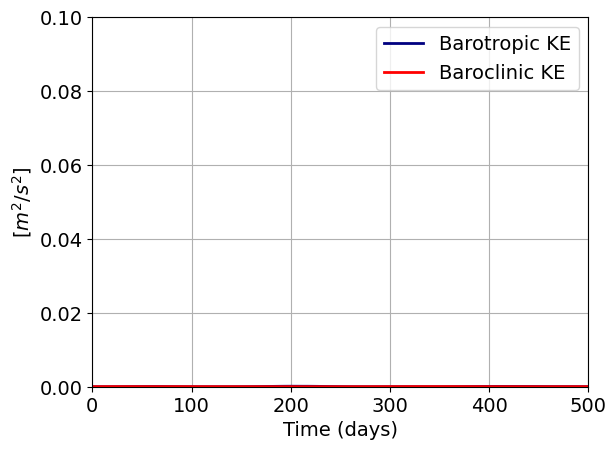

In [13]:
plt.style.use('default')
#plt.plot(u_filtered,-eta_filtered,c='c')
plt.plot(np.linspace(0,time*5,time),BT_KE,c=[0., 0., 0.5],linewidth=2,markersize=10)

#plt.plot(v_filtered,-eta_filtered,c=[0.7, 0.7, 0])
plt.plot(np.linspace(0,time*5,time),BC_KE,c=[1, 0, 0],linewidth=2,markersize=10)

plt.grid()
#plt.plot([0, 500],[0, -4000],'--',color=[0,0,0])

plt.xticks(fontsize=14); plt.yticks(fontsize=14)
plt.xlim(0, time*5)
plt.ylim(0,1e-1); 
plt.xlabel('Time (days)',fontsize=14)
plt.legend(['Barotropic KE','Baroclinic KE'],fontsize=14)
plt.ylabel('$[m^2/s^2]$',fontsize=14)
#plt.title('%i total modes' % (nmodes+1))
#plt.show()

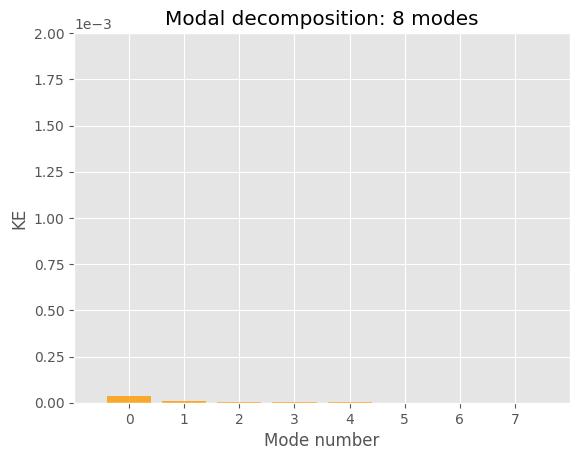

In [14]:
plt.style.use('ggplot')

x = np.linspace(0,14,15)
amp1 = np.nanmean(KE_u_t+KE_v_t,axis=0)

plt.bar(x, amp1, color=[1., .6, 0.],alpha=0.8)
plt.xlabel("Mode number")
plt.ylabel("KE")
plt.title("Modal decomposition: %i modes" % (nmodes+1))
#plt.ylim(0,3e-2)
plt.ylim(0,2e-3)
plt.xlim(-1,8)
plt.xticks((0,1,2,3,4,5,6,7))
plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))

In [15]:
c

array([191.27931087,   4.23652947,   1.97592522,   1.34847205,
         1.05455302,   0.86096697,   0.73199159,   0.64486238])

Text(0, 0.5, 'PE')

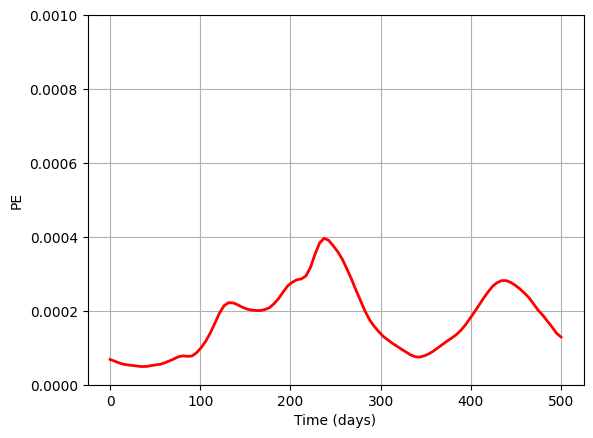

In [23]:
plt.style.use('default')
#plt.plot(u_filtered,-eta_filtered,c='c')

#plt.plot(v_filtered,-eta_filtered,c=[0.7, 0.7, 0])
plt.plot(np.linspace(0,time*5,time),BC_PE,c=[1, 0, 0],linewidth=2,markersize=10)

plt.grid()
#plt.plot([0, 500],[0, -4000],'--',color=[0,0,0])

#plt.xlim(-.3, .3)
plt.ylim(0,.001);
#plt.ylim(9.5,10.61);
plt.xlabel('Time (days)')
plt.ylabel('PE')
#plt.title('%i total modes' % (nmodes+1))
#plt.show()

([<matplotlib.axis.XTick at 0x2b2fee41a1d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

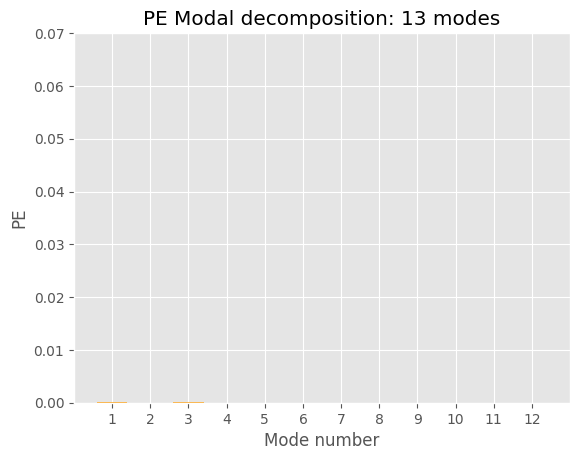

In [24]:
plt.style.use('ggplot')

nmodes=12
x = np.linspace(1,14,14)
amp1 = np.nanmean(PE_t[:,1:],axis=0)

plt.bar(x, amp1, color=[1., .6, 0.],alpha=0.8)
plt.xlabel("Mode number")
plt.ylabel("PE")
plt.title("PE Modal decomposition: %i modes" % (nmodes+1))
plt.ylim(0,0.07)
plt.xlim(0,13)
plt.xticks((1,2,3,4,5,6,7,8,9,10,11,12))
#plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))

In [25]:
PE_t.shape

(100, 15)

0


ValueError: x and y must have same first dimension, but have shapes (15,) and (16,)

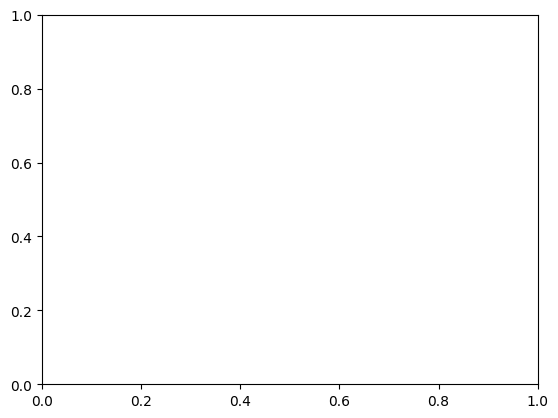

In [26]:
line_number = 5#nmodes+1

color=iter(cm.rainbow(np.linspace(0,1,line_number))) #rainbow
plt.style.use('default')
for i in range(line_number):
    print(i)
    c=next(color)
    plt.plot(Gz[:,i],-eta_mean,'.-',c=c)
plt.grid()
plt.legend(['BT','BC Mode 1','BC Mode 2','BC Mode 3','BC Mode 4','BC Mode 5','BC Mode 6','BC Mode 7','BC Mode 8','BC Mode 9','BC Mode 10','BC Mode 11','BC Mode 12'])
plt.plot([0, 0],[0, -4000],'--',color=[0,0,0])
plt.xlim(-2.5, 2.5)
plt.ylim(-4000, 0);
plt.xlabel('Normalized velocity')
plt.ylabel('Depth')
plt.title('Horizontal velocity modes')

0
1
2
3
4


Text(0.5, 1.0, 'Isopycnal displacement modes')

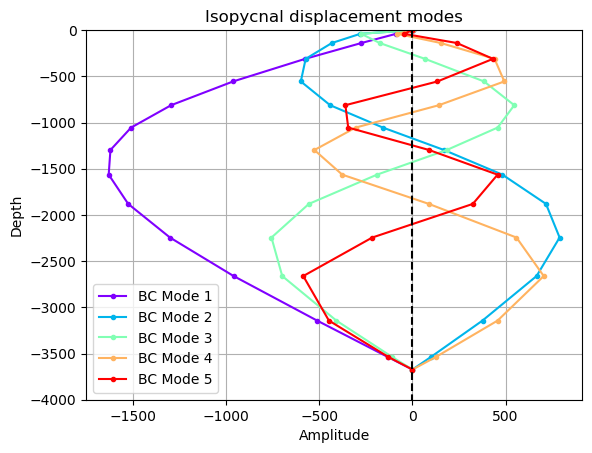

In [89]:
line_number = 5#nmodes+1

color=iter(cm.rainbow(np.linspace(0,1,line_number))) #rainbow
plt.style.use('default')
for i in range(line_number):
    print(i)
    c=next(color)
    plt.plot(G[:,i+1],-eta_mean,'.-',c=c)
plt.grid()
plt.legend(['BC Mode 1','BC Mode 2','BC Mode 3','BC Mode 4','BC Mode 5','BC Mode 6','BC Mode 7','BC Mode 8','BC Mode 9','BC Mode 10','BC Mode 11'])
plt.plot([0, 0],[0, -4000],'--',color=[0,0,0])
#plt.xlim(-100, 100)
plt.ylim(-4000, 0);
plt.xlabel('Amplitude')
plt.ylabel('Depth')
plt.title('Isopycnal displacement modes')